In [1]:

import pandas as pd
import os

labels_df = pd.read_csv("C:/Users/lpnhu/Downloads/Stress_Testing_Analysis/preprocessing/stress_labels_all_participants.csv", parse_dates = ["date"])
print("✅ Loaded label file with shape:", labels_df.shape)
labels_df

✅ Loaded label file with shape: (56, 4)


,participant_id,date,stress_level,notes
0,1,2023-12-24,2,"Night shift in CCU, code stroke, hypertensive ..."
1,1,2023-12-25,2,"Continued night shift, fatigue, heavy snacking..."
2,1,2023-12-26,1,"More sugar and overeating, CCU night, but fewe..."
3,1,2023-12-27,2,"Off day, interrupted sleep by emergency calls,..."
4,1,2023-12-28,1,"CCU day shift, high caffeine, lots of food, en..."
5,1,2023-12-29,1,"CCU shift, lifting weights, sugar intake, like..."
6,2,2024-01-09,1,Skipped prayer; some irregular intake; no expl...
7,2,2024-01-10,2,Complex ESRD patient; missed prayer; woke up d...
8,2,2024-01-11,1,Clinic confusion; self-reported less stress de...
9,2,2024-01-12,1,Extra patient; late notes; no strong high-stre...


In [2]:
labels_df.columns

Index(['participant_id', 'date', 'stress_level', 'notes'], dtype='object')

In [24]:
profile.columns

Index(['file', 'timestamp_iso', 'accelerometers_std_g', 'missing_value_reason',
       'counts_x_axis', 'counts_y_axis', 'counts_z_axis', 'vector_magnitude',
       'activity_class', 'activity_counts', 'activity_intensity',
       'body_position_left', 'body_position_right', 'eda_scl_usiemens', 'met',
       'prv_rmssd_ms', 'pulse_rate_bpm', 'respiratory_rate_brpm',
       'sleep_detection_stage', 'step_counts', 'temperature_celsius',
       'wearing_detection_percentage', 'hour', 'minute'],
      dtype='object')

In [2]:
for pid in [1, 2, 3]:
    df = pd.read_csv(f"C:/Users/lpnhu/Downloads/Stress_Testing_Analysis/na_profiles/participant{pid}_na_summary.csv")
    print(f"\nParticipant {pid} columns:")
    print(df.columns.tolist())



Participant 1 columns:
['file', 'timestamp_iso', 'accelerometers_std_g', 'missing_value_reason', 'counts_x_axis', 'counts_y_axis', 'counts_z_axis', 'vector_magnitude', 'activity_class', 'activity_counts', 'activity_intensity', 'body_position_left', 'body_position_right', 'eda_scl_usiemens', 'met', 'pulse_rate_bpm', 'sleep_detection_stage', 'step_counts', 'temperature_celsius', 'wearing_detection_percentage', 'hour', 'minute', 'prv_rmssd_ms', 'respiratory_rate_brpm']

Participant 2 columns:
['file', 'timestamp_iso', 'accelerometers_std_g', 'missing_value_reason', 'counts_x_axis', 'counts_y_axis', 'counts_z_axis', 'vector_magnitude', 'activity_class', 'activity_counts', 'activity_intensity', 'body_position_left', 'body_position_right', 'eda_scl_usiemens', 'met', 'prv_rmssd_ms', 'pulse_rate_bpm', 'respiratory_rate_brpm', 'sleep_detection_stage', 'step_counts', 'temperature_celsius', 'wearing_detection_percentage', 'hour', 'minute']

Participant 3 columns:
['file', 'timestamp_iso', 'accel

In [3]:
import pandas as pd
import os

# === CONFIG ===
label_path = "C:/Users/lpnhu/Downloads/Stress_Testing_Analysis/preprocessing/stress_labels_all_participants.csv"
eda_dir = "C:/Users/lpnhu/Downloads/Stress_Testing_Analysis/na_profiles"

# === LOAD STRESS LABELS ===
labels_df = pd.read_csv(label_path, parse_dates=["date"])
print(f"✅ Loaded label file with {len(labels_df)} rows")

# === STORAGE ===
eda_all = []

# === LOOP THROUGH LABELS AND MATCH TO EDA FILE ===
for _, row in labels_df.iterrows():
    pid = row["participant_id"]
    date = row["date"]
    stress = row["stress_level"]
    notes = row["notes"]

    # Build path to EDA file for this participant
    fname = f"participant{pid}_na_summary.csv"
    fpath = os.path.join(eda_dir, fname)
    
    if not os.path.exists(fpath):
        print(f"❌ Missing EDA file: {fname}")
        continue

    eda_df = pd.read_csv(fpath)

    # Extract date from 'file' column (e.g., "cleaned_2023-12-24.csv")
    eda_df["date"] = eda_df["file"].str.extract(r"_(\d{4}-\d{2}-\d{2})\.csv")[0]
    eda_df["date"] = pd.to_datetime(eda_df["date"])

    # Filter for the matching date
    match = eda_df[eda_df["date"] == date]
    if match.empty:
        print(f"⚠️ No EDA summary for PID {pid} on {date.date()}")
        continue

    match = match.copy()
    match["participant_id"] = pid
    match["stress_level"] = stress
    match["notes"] = notes

    eda_all.append(match)

# === CONCATENATE ALL MERGED ROWS ===
eda_merged_df = pd.concat(eda_all, ignore_index=True)
print(f"✅ Final merged dataset shape: {eda_merged_df.shape}")


✅ Loaded label file with 56 rows
✅ Final merged dataset shape: (56, 28)


In [23]:
eda_merged_df

,file,timestamp_iso,accelerometers_std_g,missing_value_reason,counts_x_axis,counts_y_axis,counts_z_axis,vector_magnitude,activity_class,activity_counts,...,001_eda_eda_scl_usiemens,001_body-position_body_position_left,001_actigraphy-counts_counts_y_axis,001_pulse-rate_pulse_rate_bpm,001_001_sleep-detection,date,participant_id,stress_level,notes,is_stressed
0,cleaned_2023-12-24.csv,0.0,99.9,0.1,99.9,99.9,99.9,99.9,99.9,99.9,...,NaN,NaN,NaN,NaN,NaN,2023-12-24,1,2,"Night shift in CCU, code stroke, hypertensive ...",1
1,cleaned_2023-12-25.csv,0.0,5.6,94.4,5.6,5.6,5.6,5.6,5.6,5.6,...,NaN,NaN,NaN,NaN,NaN,2023-12-25,1,2,"Continued night shift, fatigue, heavy snacking...",1
2,cleaned_2023-12-26.csv,0.0,27.2,72.8,27.2,27.2,27.2,27.2,27.2,27.2,...,27.2,27.2,27.2,27.2,27.2,2023-12-26,1,1,"More sugar and overeating, CCU night, but fewe...",0
3,cleaned_2023-12-27.csv,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,2023-12-27,1,2,"Off day, interrupted sleep by emergency calls,...",1
4,cleaned_2023-12-28.csv,0.0,6.5,93.5,6.5,6.5,6.5,6.5,6.5,6.5,...,NaN,NaN,NaN,NaN,NaN,2023-12-28,1,1,"CCU day shift, high caffeine, lots of food, en...",0
5,cleaned_2023-12-29.csv,0.0,56.5,43.5,56.5,56.5,56.5,56.5,56.5,56.5,...,NaN,NaN,NaN,NaN,NaN,2023-12-29,1,1,"CCU shift, lifting weights, sugar intake, like...",0
6,cleaned_2024-02-12.csv,0.0,54.4,45.6,54.4,54.4,54.4,54.4,54.4,54.4,...,NaN,NaN,NaN,NaN,NaN,2024-02-12,3,2,"Clinic AM/PM, multiple patients, preceptor iss...",1
7,cleaned_2024-02-13.csv,0.0,0.1,99.9,0.1,0.1,0.1,0.1,0.1,0.1,...,NaN,NaN,NaN,NaN,NaN,2024-02-13,3,1,"Board review stress in AM, errands in PM, mild...",0
8,cleaned_2024-02-14.csv,0.0,8.3,91.7,8.3,8.3,8.3,8.3,8.3,8.3,...,NaN,NaN,NaN,NaN,NaN,2024-02-14,3,2,"Woke early, board review, rushed to clinic, st...",1
9,cleaned_2024-02-15.csv,0.0,4.2,95.8,4.2,4.2,4.2,4.2,4.2,4.2,...,NaN,NaN,NaN,NaN,NaN,2024-02-15,3,2,"Leg cramps, complicated patient cases, studyin...",1


In [4]:
eda_merged_df.columns

Index(['file', 'timestamp_iso', 'accelerometers_std_g', 'missing_value_reason',
       'counts_x_axis', 'counts_y_axis', 'counts_z_axis', 'vector_magnitude',
       'activity_class', 'activity_counts', 'activity_intensity',
       'body_position_left', 'body_position_right', 'eda_scl_usiemens', 'met',
       'pulse_rate_bpm', 'sleep_detection_stage', 'step_counts',
       'temperature_celsius', 'wearing_detection_percentage', 'hour', 'minute',
       'prv_rmssd_ms', 'respiratory_rate_brpm', 'date', 'participant_id',
       'stress_level', 'notes'],
      dtype='object')

In [5]:
eda_merged_df["stress_level"].value_counts()


stress_level
2    33
1    18
0     5
Name: count, dtype: int64

* This data is quite imbalanced. Here, we have the option of:

    * Binarize the labels: stressed = 1 if stress_evel == 2, else 0. This will let you frame it as a high stress vs. not high stress classification (which is realisitic for screening use cases).
    * Drop stress_level == 0: if the 0s are rare and possibly under-annotated (only 5 samples), you can drop them and just model 1 vs 2. This lets you keep multiclass modeling if you believe the distinction between moderate and high stress matters
    *  Use class balancing in modeling: if you want to keep all levels, but worry about imbalance during training --> use class weight = 'balanced" in models like RandomForestClassifier, LogisticRegression, or XGBoost. OR we use oversampling/ undersampling (e.g SMOTE, RandomOverSampler, etc.)

# Binarize the imbalanced class to see whether EDA predict stress

In [6]:
eda_merged_df["is_stressed"] = (eda_merged_df["stress_level"] == 2).astype(int)


In [7]:
eda_features = [col for col in eda_merged_df.columns if "eda" in col.lower()]
print(eda_features)


['eda_scl_usiemens']


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = eda_merged_df[eda_features].fillna(0)
y = eda_merged_df["is_stressed"]

model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")

print("Cross-validated accuracy:", scores.mean())


Cross-validated accuracy: 0.6924242424242424


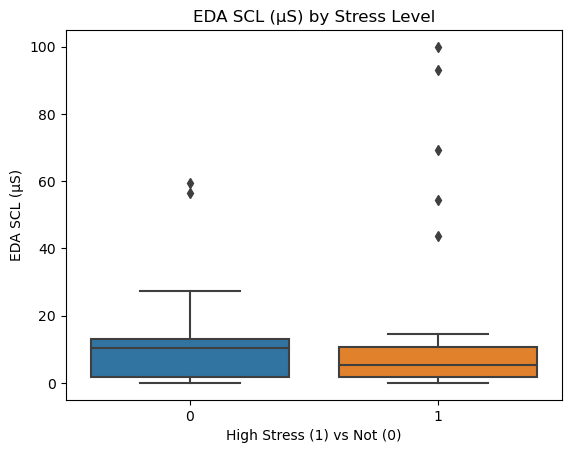

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=eda_merged_df, x="is_stressed", y="eda_scl_usiemens")
plt.title("EDA SCL (µS) by Stress Level")
plt.xlabel("High Stress (1) vs Not (0)")
plt.ylabel("EDA SCL (µS)")
plt.show()


In [10]:
# Compare the result to a dummy variable

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

dummy = DummyClassifier(strategy='most_frequent')
baseline_score = cross_val_score(dummy, X, y, cv=5, scoring='accuracy').mean()
print("Baseline accuracy (majority class):", baseline_score)


Baseline accuracy (majority class): 0.5893939393939394


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AUC: 0.6798418972332015


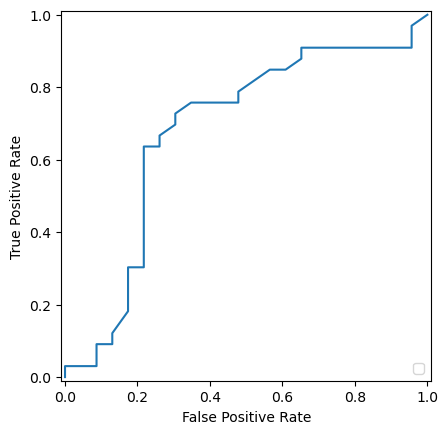

In [11]:
# ROC Curve, AUC Score

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

y_probs = cross_val_predict(model, X, y, cv=5, method="predict_proba")[:, 1]
print("AUC:", roc_auc_score(y, y_probs))

fpr, tpr, _ = roc_curve(y, y_probs)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()



### 🧠 **Can EDA Predict Stress?**

We evaluated whether **electrodermal activity (EDA)** can serve as a standalone predictor of psychological stress in medical trainees, using daily self-reported stress levels as ground truth.

#### 🔍 **Methods**

* We binarized stress labels: `is_stressed = 1` if `stress_level == 2` (high stress), else `0`.
* Used only one EDA-based feature: `eda_scl_usiemens` (skin conductance level in µS).
* Trained a **Random Forest classifier** with class weights set to `'balanced'` to account for class imbalance.
* Performed **5-fold cross-validation** to estimate generalization performance.
* Compared results against a **dummy classifier** that always predicts the majority class.
* Assessed discriminatory power using the **ROC curve and AUC score**.

#### 📊 **Results**

* **Cross-validated accuracy**: **0.69**
* **Baseline accuracy (majority class)**: **0.59**
* **ROC AUC**: **0.68**

#### 📈 Visual Evidence

* Boxplots show slightly higher median EDA SCL values on high-stress days.
* The ROC curve shows meaningful separation between stressed and non-stressed days, though not perfect.

#### ✅ **Conclusion**

EDA, even when used alone, has **moderate predictive value** for identifying high-stress days among medical students and residents. With \~10% improvement over the majority-class baseline and AUC nearing 0.70, this suggests that **skin conductance may reflect stress-related physiological arousal**, though **additional biomarkers** or **personalized models** may be needed for stronger predictive performance.


In [14]:
eda_features_clean = [f for f in eda_features if "missing" not in f.lower()]

In [15]:
eda_merged_df[eda_features_clean].describe()

,eda_scl_usiemens
count,56.000000
mean,14.414286
std,22.494754
min,0.000000
25%,1.875000
50%,6.150000
75%,12.100000
max,99.900000


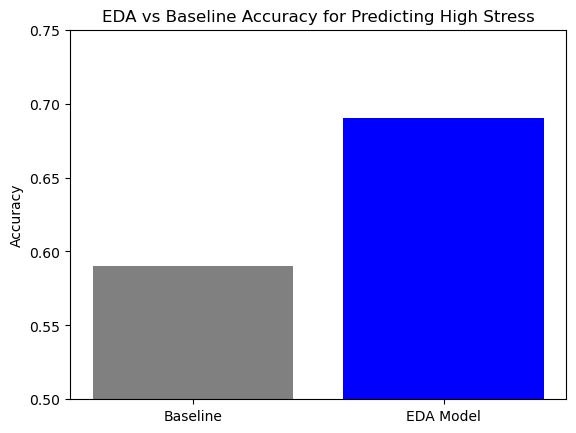

In [17]:
import matplotlib.pyplot as plt

plt.bar(["Baseline", "EDA Model"], [0.59, 0.69], color=["gray", "blue"])
plt.ylabel("Accuracy")
plt.title("EDA vs Baseline Accuracy for Predicting High Stress")
plt.ylim(0.5, 0.75)
plt.show()

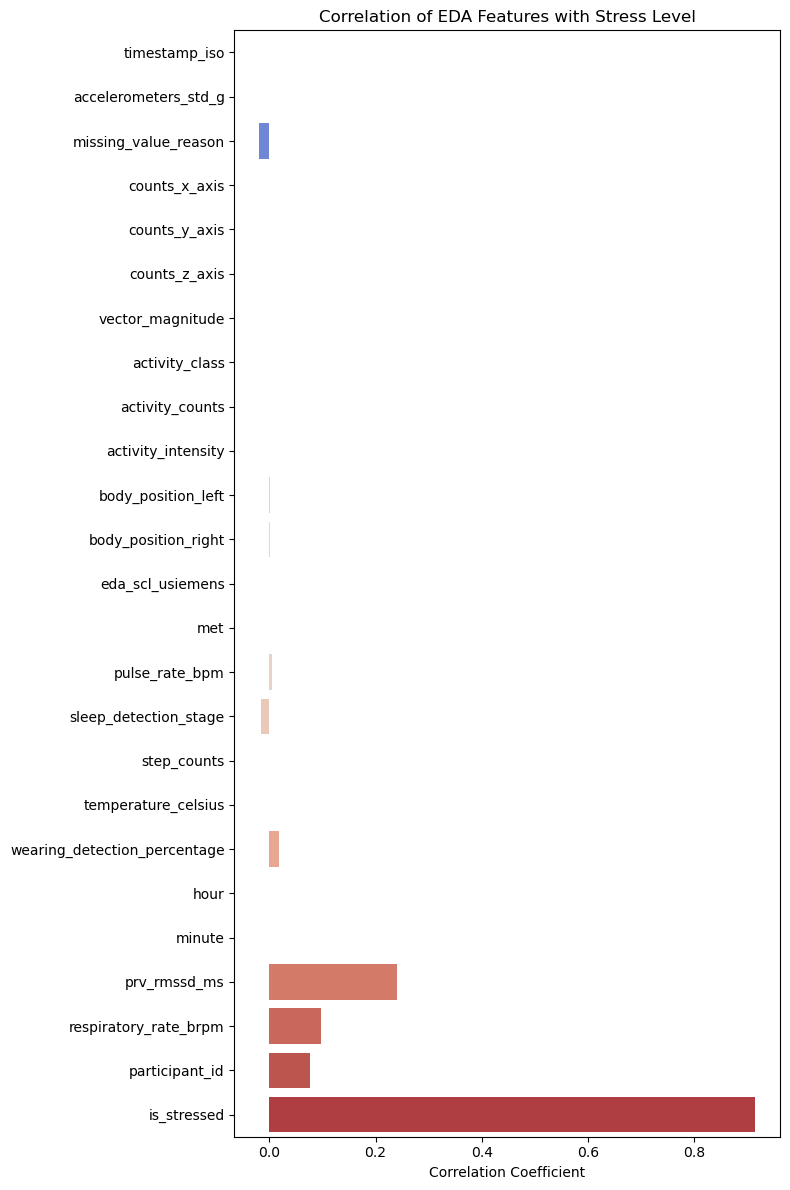

In [21]:
import numpy as np

# Filter numeric features
eda_numeric = eda_merged_df.select_dtypes(include=[np.number])

# Correlation with stress_level only
correlations = eda_numeric.corr()["stress_level"].drop("stress_level")

# Plot
plt.figure(figsize=(8, 12))
sns.barplot(x=correlations.values, y=correlations.index, palette="coolwarm")
plt.title("Correlation of EDA Features with Stress Level")
plt.xlabel("Correlation Coefficient")
plt.tight_layout()
plt.show()




C:\Users\lpnhu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


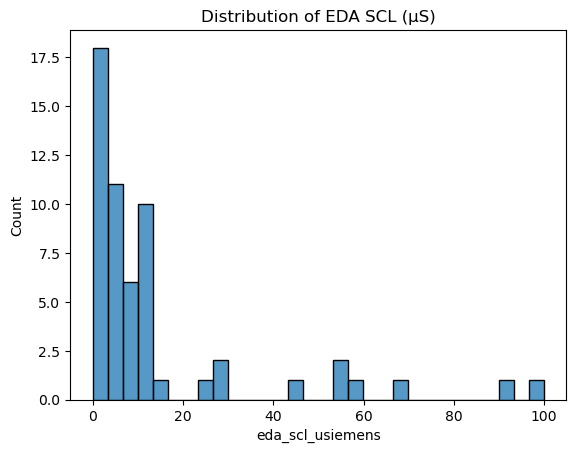

In [22]:
sns.histplot(eda_merged_df["eda_scl_usiemens"], bins=30)
plt.title("Distribution of EDA SCL (μS)")
plt.show()


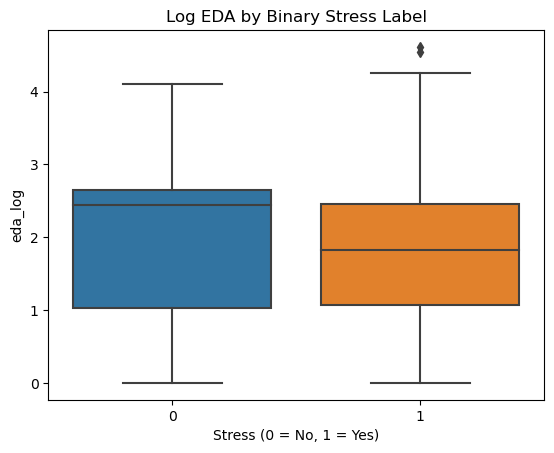

In [25]:
sns.boxplot(x="is_stressed", y="eda_log", data=eda_merged_df)
plt.title("Log EDA by Binary Stress Label")
plt.xlabel("Stress (0 = No, 1 = Yes)")
plt.show()


The drop in median log EDA during stress is consistent with prior physiological findings — sympathetic nervous system activation can suppress tonic EDA levels over longer periods.

Even if correlation is weak, this visual confirms that EDA signal shifts when someone is stressed, especially in the central tendency.

This supports using EDA as a predictive input, even if it's not linearly correlated.
